# CALCULATING PSEUDOTIME FOR MOUSE CELLS

In this notebook, we preprocess the mouse data using scanpy tools, and integrate the samples using ingest. We then calculate diffusion pseudotime, and prepare the metadata and data matrices for further downstream analyses in both python and R.

In [2]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from sklearn import preprocessing
import magic
import math
import rpy2
import bbknn
import anndata as ad
import scvelo as scv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn

from IPython.display import clear_output
import pickle
import os
import sys

import scanpy as sc
import scanpy.external as sce

from numpy import ones,vstack
from numpy.linalg import lstsq

In [3]:
#import cell cycle genes
mu_s_genes = ["Mcm4", "Exo1", "Slbp", "Gmnn", "Cdc45", "Msh2", "Mcm6", "Rrm2", "Pold3", "Blm", 
 "Ubr7", "Mcm5", "Clspn", "Hells", "Nasp", "Rpa2", "Rad51ap1", "Tyms", "Rrm1", "Rfc2", 
"Prim1", "Brip1", "Usp1", "Ung",  "Pola1", "Mcm2", "Fen1", "Tipin", "Pcna", "Cdca7",
"Uhrf1", "Casp8ap2", "Cdc6", "Dscc1", "Wdr76", "E2f8", "Dtl", "Ccne2", "Atad2", "Gins2", 
"Chaf1b", "Pcna-ps2"]
mu_g2m_genes = ["Nuf2", "Psrc1", "Ncapd2", "Ccnb2", "Smc4", "Lbr", "Tacc3", "Cenpa", "Kif23", "Cdca2", "Anp32e", 
"G2e3", "Cdca3", "Anln", "Cenpe", "Gas2l3", "Tubb4b", "Cenpf", "Dlgap5", "Hjurp", "Cks1brt", "Gtse1", 
"Bub1", "Birc5", "Ube2c", "Rangap1", "Hmmr", "Ect2", "Tpx2", "Ckap5", "Cbx5", "Nek2", "Ttk", 
"Cdca8", "Nusap1", "Ctcf", "Cdc20", "Cks2", "Mki67", "Tmpo", "Ckap2l", "Aurkb", "Kif2c", "Cdk1", 
"Kif20b", "Top2a", "Aurka", "Ckap2", "Hmgb2", "Cdc25c", "Ndc80", "Kif11"]

In [4]:
#import data
mu_int_raw = sc.read_h5ad("C:/Users/Ji Lab/Documents/JID Manuscript/mouse_uw/mu_int_ife_filt_integrated.h5ad")
mu_rna_raw = sc.read_h5ad("C:/Users/Ji Lab/Documents/JID Manuscript/mouse_uw/mu_int_ife_filt_RNA.h5ad")

mu_int = mu_int_raw.copy()
mu_rna= mu_rna_raw.copy()

In [5]:
#function for converting numerical cluster IDs
def subcell_conv (row):
    if row['integrated_snn_res.0.4'] == 0:
        return "Bas_II"
    if row['integrated_snn_res.0.4'] == 1:
        return "Bas_III"
    if row['integrated_snn_res.0.4'] == 2:
        return "Spn_I"
    if row['integrated_snn_res.0.4'] == 3:
        return "Spn_II"
    if row['integrated_snn_res.0.4'] == 4:
        return "Bas_I"
    if row['integrated_snn_res.0.4'] == 5:
        return "Cyc_I"
    if row['integrated_snn_res.0.4'] == 6:
        return "Cyc_III"
    if row['integrated_snn_res.0.4'] == 7:
        return "Cyc_II"
    if row['integrated_snn_res.0.4'] == 8:
        return "Grn"
    if row['integrated_snn_res.0.4'] == 9:
        return "Bas_IFN"
    else:
        return "broke"

In [6]:
#apply function to create 'subcell' cluster identities from 'integrated_snn_res.0.4' cluster identities
mu_rna.obs['subcell'] = mu_rna.obs.apply(lambda row: subcell_conv(row), axis=1)

In [7]:
#convert cluster identities from numeric to character, for graphing purposes
mu_rna.obs['integrated_snn_res.0.4'] = mu_rna.obs['integrated_snn_res.0.4'].astype(str)

In [8]:
#filter out genes that are not expressed in at least 1 cell
sc.pp.filter_genes(mu_rna, min_cells=1)
#calculate qc_metrics
sc.pp.calculate_qc_metrics(mu_rna, inplace = True)

In the mouse dataset, several outliers were observed that had extreme pseudotime values. These cells correspondingly had abnormally high numbers of genes expressed. This was attributed to the fact that the diffusion pseudotime algorithm had difficulty placing these outliers with unusual expression profiles on the pseudotime trajectory. They were therefore removed by filtering out the top 1% of cells with the highest number of features. These steps were not applied to the human data, since the data did not have similar outliers.


In [9]:
#filtering out top 1% of cells with the highest number of features
mu_rna = mu_rna[mu_rna.obs['n_genes_by_counts'] < np.percentile(mu_rna.obs['n_genes_by_counts'],99)]

In [10]:
sc.pp.normalize_total(mu_rna)
sc.pp.log1p(mu_rna)

In [11]:
#calculate highly_variable_genes (NOT USED IN ANY ANALYSIS)
sc.pp.highly_variable_genes(mu_rna, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=5000)

In [12]:
#Score cell cycle
sc.tl.score_genes_cell_cycle(mu_rna, s_genes=[x for x in mu_s_genes if x in mu_rna.var_names], 
                             g2m_genes=[x for x in mu_g2m_genes if x in mu_rna.var_names], use_raw=False)

In [13]:
#regress out seurat measure of the total number of molecules detected within a cell, and S_score and G2M_score
sc.pp.regress_out(mu_rna, ['nCount_RNA','S_score', 'G2M_score'])

In [14]:
sc.pp.pca(mu_rna)
sc.pp.neighbors(mu_rna, n_pcs = 20, n_neighbors=25)
sc.tl.umap(mu_rna, spread = 1, min_dist = 0.5)

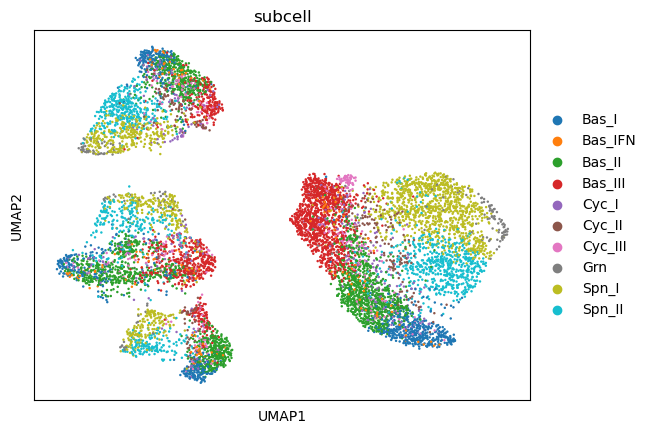

In [287]:
sc.pl.umap(mu_rna, color='subcell')

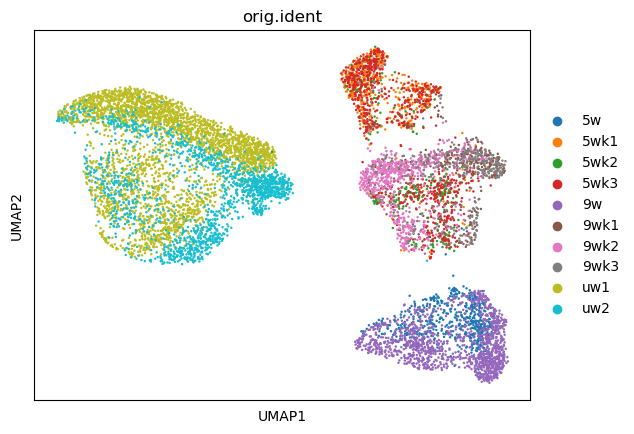

In [17]:
sc.pl.umap(mu_rna, color='orig.ident')

## Integrating samples using ingest

As indicated in the above UMAP colored by "orig.ident" identity, there are strong batch effects that need to be corrected through integration of the data. This was accomplished by using the pca-based integration method ingest within scanpy.

For the mouse data, the sample "uw1" was used as the reference data because it had the most cells.

In [21]:
mu_rna.obs['orig.ident'].value_counts()

uw1     3234
uw2     1615
9w      1279
5wk3     771
9wk2     674
5w       571
5wk1     555
9wk1     363
9wk3     335
5wk2     292
Name: orig.ident, dtype: int64

In [22]:
mu_rna_ref = mu_rna[mu_rna.obs['orig.ident'] == 'uw1']

In [289]:
sc.pp.pca(mu_rna_ref)
sc.pp.neighbors(mu_rna_ref)
sc.tl.umap(mu_rna_ref)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:07)


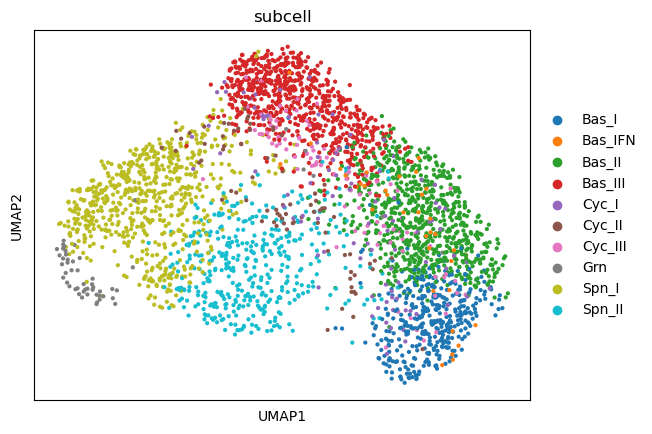

In [290]:
sc.pl.umap(mu_rna_ref, color='subcell')

In [291]:
adatas = [mu_rna[mu_rna.obs['orig.ident'] == i].copy() for i in ['uw2', '5w', '5wk1', '5wk2', '5wk3', '9w', '9wk1', '9wk2', '9wk3']]

In [292]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['subcell_orig'] = adata.obs.subcell  # save the original cell type
    sc.tl.ingest(adata, mu_rna_ref, obs='subcell')

... integrating batch 1
running ingest
    finished (0:00:16)
... integrating batch 2
running ingest
    finished (0:00:09)
... integrating batch 3
running ingest
    finished (0:00:08)
... integrating batch 4
running ingest
    finished (0:00:06)
... integrating batch 5
running ingest
    finished (0:00:10)
... integrating batch 6
running ingest
    finished (0:00:13)
... integrating batch 7
running ingest
    finished (0:00:05)
... integrating batch 8
running ingest
    finished (0:00:08)
... integrating batch 9
running ingest
    finished (0:00:05)


In [293]:
mu_rna_concat = mu_rna_ref.concatenate(adatas)

In [294]:
mu_rna_concat.obs.subcell = mu_rna_concat.obs.subcell.astype('category')
mu_rna_concat.obs.subcell.cat.reorder_categories(mu_rna_ref.obs.subcell.cat.categories, inplace=True)  # fix category ordering
mu_rna_concat.uns['subcell_colors'] = mu_rna_ref.uns['subcell_colors']  # fix category coloring

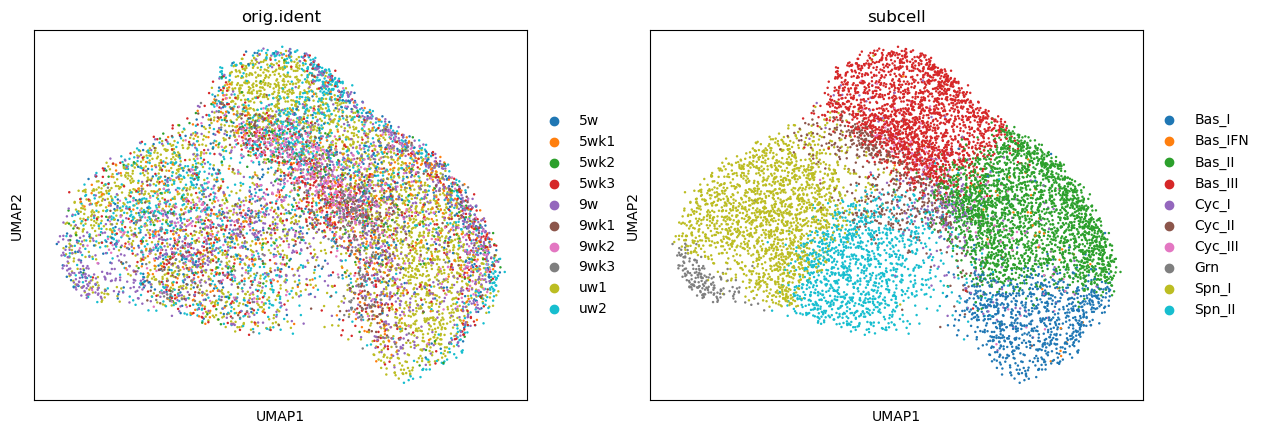

In [295]:
sc.pl.umap(mu_rna_concat, color=['orig.ident', 'subcell'])


# Calculating diffusion pseudotime

Basal II was chosen as the root cluster for diffusion pseudotime. 

In [296]:
mu_rna_concat.uns['iroot'] = np.flatnonzero(mu_rna_concat.obs['subcell']  == 'Bas_II')[0]

In [25]:
sc.pp.neighbors(mu_rna_concat)
sc.tl.diffmap(mu_rna_concat)

NameError: name 'mu_rna_concat' is not defined

In [299]:
sc.tl.dpt(mu_rna_concat)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


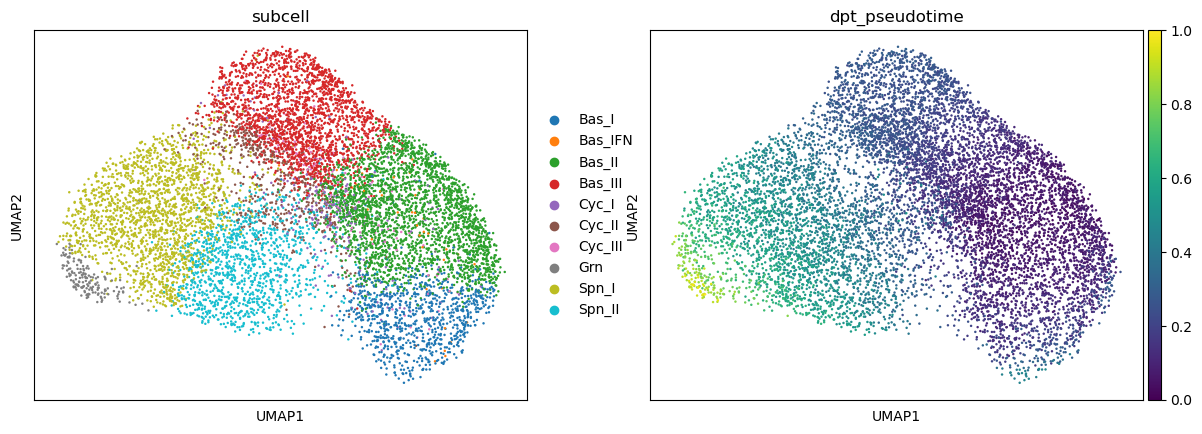

In [300]:
sc.pl.umap(mu_rna_concat, color = ['subcell','dpt_pseudotime'], ncols = 2, use_raw = False)

# Exporting anndata object

Due to issues with converting anndata objects into seurat objects, we separately exported the data matrix and metadata for manual reconstruction within R.

In [301]:
#renaming index (will not save h5ad correctly otherwise) 
mu_rna_concat.__dict__['_raw'].__dict__['_var'] = mu_rna_concat.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [302]:
#writing h5ad for downstream python analyses 
mu_rna_concat.write("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_concat_ag.h5ad")

In [303]:
#unused, metadata format not optimal
mu_rna_concat.write_csvs("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_concat_ag", skip_data=False)

In [304]:
#export scaled data matrix
pd.DataFrame(mu_rna_concat.X).to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_concat_ag_X.csv")

In [ ]:
#export raw count matrix
mu_rna_concat_raw_X_dense = pd.DataFrame(mu_rna_concat.raw.X.todense())
mu_rna_concat_raw_X_dense.to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_concat_ag_raw_X.csv")

In [307]:
#export metadata
mu_rna_concat.obs.to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_concat_ag_obs.csv")

In [308]:
#export var for subsetted gene names, to be used in creating seurat object
mu_rna_concat.var.to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_concat_ag_var.csv")

In [309]:
#export raw var for variable names, to be used in creating seurat object
mu_rna_raw.var.to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_raw_ag_var.csv")

In [310]:
#export umap and pca embeddings 
pd.DataFrame(mu_rna_concat.obsm['X_umap']).to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_concat_ag_umap.csv")
pd.DataFrame(mu_rna_concat.obsm['X_pca']).to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_concat_ag_pca.csv")

In [311]:
mu_rna_concat.var

,features,n_cells,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
Xkr4,Xkr4,90,90,0.004985,0.004973,99.071112,48.300102,3.897926,False,0.004597,0.051450,0.068760
Sox17,Sox17,3,3,0.000522,0.000522,99.969037,5.062039,1.802046,True,0.000768,1.162158,1.983491
Mrpl15,Mrpl15,3117,3117,0.274760,0.242758,67.829497,2662.149594,7.887265,False,0.243918,0.172870,-0.354491
Lypla1,Lypla1,3058,3058,0.270469,0.239386,68.438435,2620.577096,7.871531,False,0.238827,0.088079,-1.208157
Gm37988,Gm37988,6,6,0.000480,0.000480,99.938074,4.648391,1.731371,False,0.000470,-0.143824,-0.267870
...,...,...,...,...,...,...,...,...,...,...,...,...
2310034G01Rik,2310034G01Rik,20,20,0.000903,0.000903,99.793580,8.751813,2.277453,False,0.000772,0.106569,0.163778
Stn1,Stn1,243,243,0.012291,0.012216,97.492001,119.085969,4.788208,True,0.011050,0.308914,0.512598
Ccl27.1,Ccl27.1,2,2,0.000085,0.000085,99.979358,0.822654,0.600294,False,0.000069,-1.092114,-1.902612
AC149090.1,AC149090.1,1540,1540,0.136992,0.128387,84.105687,1327.320117,7.191670,False,0.110719,0.195185,-0.312805
